# Introduction

This notebook is inspired by text classification notebooks [1][2][3] in kaggle. A dataset consisting of sarcasm from various news headlines is observed. It consists of 3 columns, i.e. is_sarcastic, headlines, and article_link. We use text from headlines column to identify any unusual patterns to know if the headline is sarcastic or not. Since, the data is labeled, we split the data to later verify if our models perform well for any unseen data in future. After preprocessing and cleaning, we aim to use word embedding techniques that include:<br>-Glove<br>-Word2Vec <br>The word embeddings are used long with various model architectures of deep neural networks to find our an optimal one future predictions,including:<br> -LSTM<br>-GRU<br>In the end, we conclude by comparing the models and finding out which model performed the best on all subsets i.e.training, testing and validation sets.

# Exploratory Data Analysis

## Importing all required libraries

In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing import text,sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout, GRU
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Reading Sarcasm dataset json file

In [2]:
df = pd.read_json('/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json', lines=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [4]:
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [5]:
df.isna().sum() # Checking for NaN values

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [6]:
df.is_sarcastic.unique()

array([1, 0])

<AxesSubplot:xlabel='is_sarcastic', ylabel='count'>

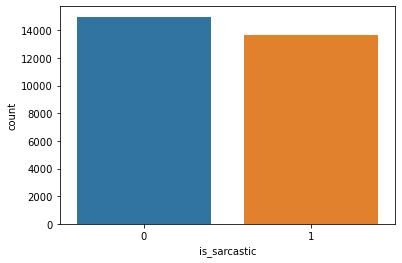

In [7]:
sns.countplot(x='is_sarcastic', data=df)

# Preprocess the dataset

## Preprocessing Function the textual column for cleaning

In [8]:
stop_words = stopwords.words('english') #English language's stop words

def textpreprocess(s):
    """This function cleans the text
    Input: string to be cleaned
    Return: string after cleaning
    """
    words = [] # empty list
    
    s = s.strip().lower() # lower the string
    s = re.sub('\[.*?\]', '', s) # removes symbols (.*?\)
    s = re.sub('https?://\S+|www\.\S+', '', s) # remove URLS
    s = re.sub('<.*?>+', '', s)
    s = re.sub('[%s]' % re.escape(string.punctuation), '', s) # remove punctuations
    s = re.sub('\n', '', s) # remove next line character
    s = re.sub('\w*\d\w*', '', s)
    
    words = s.split() # split the string into list of words
    words = [word for word in words if word not in stop_words] # removing stop words
    s = ' '.join(words) # converting list to string
    
    return s

## Apply preprocessing function to all the rows

In [9]:
X = []
sentences = list(df['headline'])
for sen in sentences:
    X.append(textpreprocess(sen))

In [10]:
X[6]

'ways file taxes less stress'

In [11]:
y=df['is_sarcastic']

## Split data into train, test and validation sets

In [12]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

## Tokenization

Tokenization of sentences, with 5000 words, skipping words that are out of vocabulary

In [13]:
# hyperparameters
num_words_ = 5000
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=num_words_, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)


#converting text to sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

## Padding sequences for equal length

In [14]:
vocab_size = len(tokenizer.word_index)

maxlen = 150
trunc_type='post'
padding_type='post'

X_train = pad_sequences(X_train, maxlen=maxlen, truncating= trunc_type, padding=padding_type)
X_val = pad_sequences(X_val, maxlen=maxlen , padding='post')
X_test = pad_sequences(X_test, maxlen=maxlen, padding='post')

# Deep Neural Networks

## Model1: Creating initial baseline model architecture, with embedding layer

### Model Architecture

In [15]:
model1 = Sequential()
embedding_layer = Embedding(vocab_size, 50, input_length=maxlen , trainable=True)
model1.add(embedding_layer)
model1.add(LSTM(64,return_sequences=True))
model1.add(LSTM(64,return_sequences=True))
model1.add(Dense(1, activation='sigmoid'))

2023-02-13 04:20:25.042845: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 04:20:25.043818: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 04:20:25.053275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 04:20:25.054113: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 04:20:25.054822: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

### Compile the model

In [16]:
model1.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

print(model1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 50)           1286700   
_________________________________________________________________
lstm (LSTM)                  (None, 150, 64)           29440     
_________________________________________________________________
lstm_1 (LSTM)                (None, 150, 64)           33024     
_________________________________________________________________
dense (Dense)                (None, 150, 1)            65        
Total params: 1,349,229
Trainable params: 1,349,229
Non-trainable params: 0
_________________________________________________________________
None


### Model training

In [17]:
history1 = model1.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_data=(X_val, y_val))

2023-02-13 04:20:27.611085: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2023-02-13 04:20:30.993400: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


179/179 [==============================] - 9s 26ms/step - loss: 0.6952 - accuracy: 0.5364 - val_loss: 0.6776 - val_accuracy: 0.5208
Epoch 2/5
179/179 [==============================] - 4s 24ms/step - loss: 0.5479 - accuracy: 0.7461 - val_loss: 0.5430 - val_accuracy: 0.7549
Epoch 3/5
179/179 [==============================] - 4s 22ms/step - loss: 0.4503 - accuracy: 0.8103 - val_loss: 0.4744 - val_accuracy: 0.7840
Epoch 4/5
179/179 [==============================] - 5s 27ms/step - loss: 0.3925 - accuracy: 0.8368 - val_loss: 0.6755 - val_accuracy: 0.6864
Epoch 5/5
179/179 [==============================] - 4s 22ms/step - loss: 0.4170 - accuracy: 0.8189 - val_loss: 0.4713 - val_accuracy: 0.7812


### Predicting on Test set

In [18]:
from sklearn.metrics import roc_auc_score, accuracy_score

output_test = model1.predict(X_test)
print("test auc:", roc_auc_score(y_test,output_test[:,1])) #77%

test auc: 0.7776165968564929


### Check Loss and accuracy for Training and validation sets

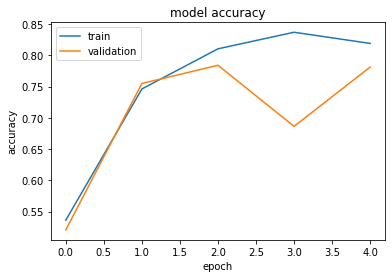

In [19]:
plt.subplots()
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

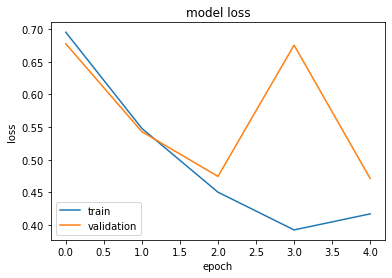

In [20]:
plt.subplots() 
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

##### Test accuracy is 77% which is okay for our first model. But our model seems to be overfitting after a certain number of epochs.

## Model2: Creating a Model using Glove 50 dimension embedding

In [21]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/kaggle/input/glove6b50dtxt/glove.6B.50d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

vocab_size = len(tokenizer.word_index)+1

#creating a embedding matrix for initial weights based on the precreated glove embedding

embedding_matrix = zeros((vocab_size, 50))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


### Model Architecture

In [22]:
model2 = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model2.add(embedding_layer)
model2.add(LSTM(64,return_sequences=True))
model2.add(LSTM(64,return_sequences=True))
model2.add(Dense(1, activation='sigmoid'))

### Compile the model

In [23]:
model2.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 50)           1286750   
_________________________________________________________________
lstm_2 (LSTM)                (None, 150, 64)           29440     
_________________________________________________________________
lstm_3 (LSTM)                (None, 150, 64)           33024     
_________________________________________________________________
dense_1 (Dense)              (None, 150, 1)            65        
Total params: 1,349,279
Trainable params: 62,529
Non-trainable params: 1,286,750
_________________________________________________________________
None


### Model Training

##### In addition, we also increase number of epochs to see the big picture, incase model is converging later 

In [24]:
history2 = model2.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_data=(X_val, y_val))

Epoch 1/50
179/179 [==============================] - 8s 25ms/step - loss: 0.6265 - accuracy: 0.6506 - val_loss: 0.6258 - val_accuracy: 0.6900
Epoch 2/50
179/179 [==============================] - 4s 23ms/step - loss: 0.5692 - accuracy: 0.7116 - val_loss: 0.5556 - val_accuracy: 0.7170
Epoch 3/50
179/179 [==============================] - 4s 22ms/step - loss: 0.5387 - accuracy: 0.7344 - val_loss: 0.5239 - val_accuracy: 0.7402
Epoch 4/50
179/179 [==============================] - 4s 24ms/step - loss: 0.5172 - accuracy: 0.7480 - val_loss: 0.5050 - val_accuracy: 0.7479
Epoch 5/50
179/179 [==============================] - 4s 23ms/step - loss: 0.5120 - accuracy: 0.7501 - val_loss: 0.5195 - val_accuracy: 0.7392
Epoch 6/50
179/179 [==============================] - 4s 21ms/step - loss: 0.4935 - accuracy: 0.7665 - val_loss: 0.5583 - val_accuracy: 0.7276
Epoch 7/50
179/179 [==============================] - 4s 21ms/step - loss: 0.4799 - accuracy: 0.7706 - val_loss: 0.4992 - val_accuracy: 0.7551

### Predict on test set

In [25]:
from sklearn.metrics import roc_auc_score, accuracy_score

output_test = model2.predict(X_test)
print("test auc:", roc_auc_score(y_test,output_test[:,1])) #76%

test auc: 0.758191954221981


### Check Loss and accuracy of Train and validation sets

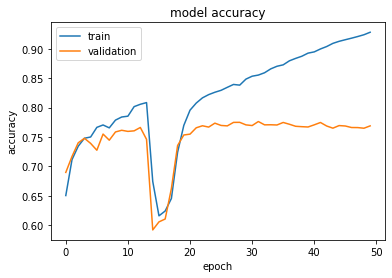

In [26]:
plt.subplots()
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

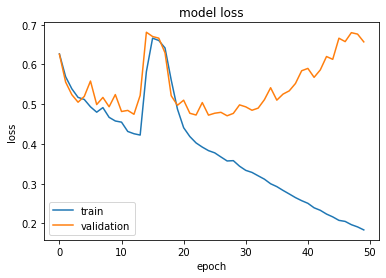

In [27]:
plt.subplots() 
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

##### After using Glove embedding, we get a test accuracy of 75%. Model is still overfitting after using glove embedding. Also increasing number of epochs wasn't helpful.

## Model 3: Using Dropout layer to reduce overfitting (with GloVe Embedding)

### Model Architecture

In [28]:
model3 = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model3.add(embedding_layer)
model3.add(Dropout(0.3))
model3.add(LSTM(64,return_sequences=True))
model3.add(LSTM(64,return_sequences=True))
model3.add(Dense(1, activation='sigmoid'))

### Compile the Model 

In [29]:
model3.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

print(model3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 50)           1286750   
_________________________________________________________________
dropout (Dropout)            (None, 150, 50)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 150, 64)           29440     
_________________________________________________________________
lstm_5 (LSTM)                (None, 150, 64)           33024     
_________________________________________________________________
dense_2 (Dense)              (None, 150, 1)            65        
Total params: 1,349,279
Trainable params: 62,529
Non-trainable params: 1,286,750
_________________________________________________________________
None


### Model Training

In [30]:
history3 = model3.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(X_val, y_val))

Epoch 1/10
179/179 [==============================] - 8s 30ms/step - loss: 0.6507 - accuracy: 0.6213 - val_loss: 0.6151 - val_accuracy: 0.6838
Epoch 2/10
179/179 [==============================] - 4s 24ms/step - loss: 0.6131 - accuracy: 0.6678 - val_loss: 0.5645 - val_accuracy: 0.7085
Epoch 3/10
179/179 [==============================] - 5s 26ms/step - loss: 0.5803 - accuracy: 0.7013 - val_loss: 0.5439 - val_accuracy: 0.7257
Epoch 4/10
179/179 [==============================] - 4s 24ms/step - loss: 0.5651 - accuracy: 0.7124 - val_loss: 0.5257 - val_accuracy: 0.7420
Epoch 5/10
179/179 [==============================] - 5s 28ms/step - loss: 0.5623 - accuracy: 0.7133 - val_loss: 0.5505 - val_accuracy: 0.7149
Epoch 6/10
179/179 [==============================] - 5s 26ms/step - loss: 0.5521 - accuracy: 0.7177 - val_loss: 0.5293 - val_accuracy: 0.7399
Epoch 7/10
179/179 [==============================] - 4s 24ms/step - loss: 0.5444 - accuracy: 0.7214 - val_loss: 0.5162 - val_accuracy: 0.7473

### Predicting on Test set

In [31]:
from sklearn.metrics import roc_auc_score, accuracy_score

output_test = model3.predict(X_test)
print("test auc:", roc_auc_score(y_test,output_test[:,1])) #73%

test auc: 0.7287361187664062


### Check Loss and accuracy of Train and validation set

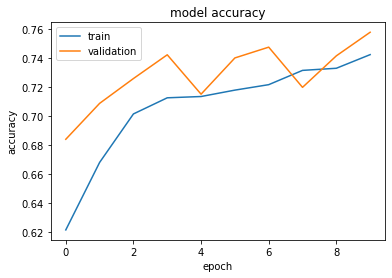

In [32]:
plt.subplots()
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

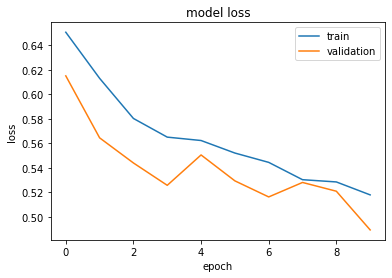

In [33]:
plt.subplots() 
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

##### We get a test accuracy of 65%, our model needs some better approach for reducing overfitting

## Model4: Using Adam optimizer, Dropout layer and GRU with GloVe Embedding

### Model Architecture

In [34]:
model4 = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model4.add(embedding_layer)
model4.add(GRU(128,return_sequences=True))
model4.add(Dropout(0.3))
model4.add(Dense(1, activation='sigmoid'))

### Compile the model

In [35]:
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model4.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 150, 50)           1286750   
_________________________________________________________________
gru (GRU)                    (None, 150, 128)          69120     
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 128)          0         
_________________________________________________________________
dense_3 (Dense)              (None, 150, 1)            129       
Total params: 1,355,999
Trainable params: 69,249
Non-trainable params: 1,286,750
_________________________________________________________________
None


### Model Training

In [36]:
history4 = model4.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_data=(X_val, y_val))

Epoch 1/6
179/179 [==============================] - 5s 15ms/step - loss: 0.6637 - accuracy: 0.5883 - val_loss: 0.5946 - val_accuracy: 0.6824
Epoch 2/6
179/179 [==============================] - 3s 14ms/step - loss: 0.5862 - accuracy: 0.6962 - val_loss: 0.5521 - val_accuracy: 0.7188
Epoch 3/6
179/179 [==============================] - 2s 13ms/step - loss: 0.5431 - accuracy: 0.7255 - val_loss: 0.5519 - val_accuracy: 0.7192
Epoch 4/6
179/179 [==============================] - 2s 13ms/step - loss: 0.5078 - accuracy: 0.7489 - val_loss: 0.4983 - val_accuracy: 0.7514
Epoch 5/6
179/179 [==============================] - 2s 13ms/step - loss: 0.4829 - accuracy: 0.7629 - val_loss: 0.5013 - val_accuracy: 0.7501
Epoch 6/6
179/179 [==============================] - 2s 13ms/step - loss: 0.4647 - accuracy: 0.7735 - val_loss: 0.4769 - val_accuracy: 0.7702


### Predicting on Test set

In [37]:
from sklearn.metrics import roc_auc_score, accuracy_score

output_test = model4.predict(X_test)
print("test auc:", roc_auc_score(y_test,output_test[:,1])) #72%

test auc: 0.7257013184916109


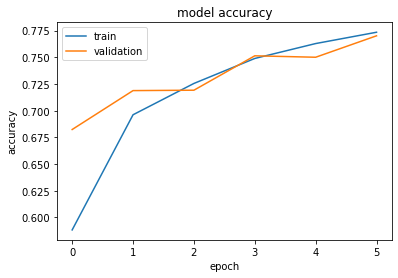

In [38]:
plt.subplots()
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

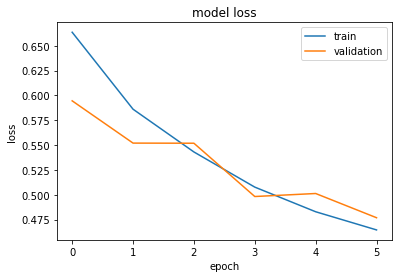

In [39]:
plt.subplots() 
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

##### Our test set gives accuracy of 72% which is still less but we can see that model performs better (less overfitted). This might be because of using GRU instead of using LSTM.

## Model5: Using Adam optimizer, GRU with Word2Vec Embedding

#### Converting text to format acceptable by gensim

In [40]:
words = []
for i in df.headline.values:
    words.append(i.split())
words[:5]

import gensim

w2v_model = gensim.models.Word2Vec(sentences = words , vector_size=150 , window = 5 , min_count = 1)

tokenizer = text.Tokenizer(num_words=30000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = 20)

vocab_size = len(tokenizer.word_index) + 1

In [41]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, 150))
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix


In [42]:
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

In [43]:
model5 = Sequential()
embedding_layer = Embedding(vocab_size, 150, weights=[embedding_vectors], input_length=maxlen , trainable=True)
model5.add(embedding_layer)
model5.add(GRU(128,return_sequences=True))
model5.add(Dropout(0.3))
model5.add(Dense(1, activation='sigmoid'))

In [44]:
model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model5.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 150, 150)          5735250   
_________________________________________________________________
gru_1 (GRU)                  (None, 150, 128)          107520    
_________________________________________________________________
dropout_2 (Dropout)          (None, 150, 128)          0         
_________________________________________________________________
dense_4 (Dense)              (None, 150, 1)            129       
Total params: 5,842,899
Trainable params: 5,842,899
Non-trainable params: 0
_________________________________________________________________
None


In [45]:
history5 = model5.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_data=(X_val, y_val))

Epoch 1/6
179/179 [==============================] - 5s 21ms/step - loss: 0.6915 - accuracy: 0.5233 - val_loss: 0.6911 - val_accuracy: 0.5303
Epoch 2/6
179/179 [==============================] - 3s 17ms/step - loss: 0.6873 - accuracy: 0.5416 - val_loss: 0.6859 - val_accuracy: 0.5424
Epoch 3/6
179/179 [==============================] - 3s 19ms/step - loss: 0.5696 - accuracy: 0.6707 - val_loss: 0.4576 - val_accuracy: 0.7845
Epoch 4/6
179/179 [==============================] - 3s 17ms/step - loss: 0.3607 - accuracy: 0.8425 - val_loss: 0.4381 - val_accuracy: 0.7958
Epoch 5/6
179/179 [==============================] - 3s 18ms/step - loss: 0.3062 - accuracy: 0.8714 - val_loss: 0.4708 - val_accuracy: 0.7884
Epoch 6/6
179/179 [==============================] - 3s 17ms/step - loss: 0.2682 - accuracy: 0.8901 - val_loss: 0.4930 - val_accuracy: 0.7923


In [46]:
output_test = model5.predict(X_test)
print("test auc:", roc_auc_score(y_test,output_test[:,1])) #78%

test auc: 0.7846848081357043


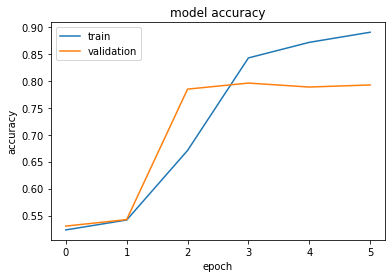

In [47]:
plt.subplots()
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()


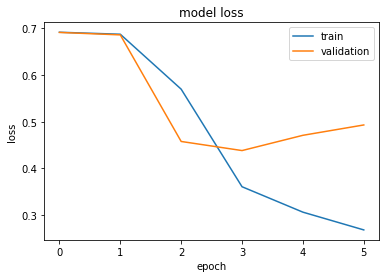

In [48]:
plt.subplots() 
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
model.save('model5.h5')

# Conclusion

In the above notebook, the intent was to practise and implement various techniques for textual dataset and to eventually find out which technique performs well.<br>
We used various notebooks(see references) as inspiration to start our research for embedding techniques in Natural Language Processing (NLP).<br> Combining our research with Neural Network Architectures with embeddings and then hyperparameter tuning, We found that in  Word2Vec embedding with a vector size of 150, trained over a 3 layered GRU neural network, provided adam optimizer with default learning rate(0.001), performs well out of all the other models that were tested with Glove embedding (50 dimension).<br> Our best model(model5) provides an accuracy of 77%. In terms of overfitting, model4 performed well, using GRU with GloVe. <br> We aim to improve this accuracy in future by trying other techniques such as Transformers. We also need to work on dealing with overfitting of training dataset by using methods such as Early Stopping and checkpoints. 

Inspired from notebooks:

[1] https://www.kaggle.com/code/eliotbarr/text-classification-using-neural-networks
<br>
[2] https://www.kaggle.com/code/madz2000/sarcasm-detection-with-glove-word2vec-83-accuracy
<br>
[3] https://www.kaggle.com/code/atishadhikari/fake-news-cleaning-word2vec-lstm-99-accuracy

**Authors of this notebook:**
Murk Asad,
Fairouz Sharif